In [33]:
import pickle
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, AdamW
from transformers.optimization import get_constant_schedule_with_warmup
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import matplotlib.pyplot as plt
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

print("DONE!!!")

DONE!!!


In [34]:
print("Datasets......\n1. SNLI \n2. MULTI-NLI\n3. SICK")
for i in range(3):
    dataset_choice = int(input("Enter choice :"))
    if dataset_choice == 1:
        dataset = load_dataset("snli")
        break
    elif dataset_choice == 2:
        dataset = load_dataset("multi_nli")
        break
    elif dataset_choice == 3:
        dataset =  load_dataset("sick")
        break
else:
    print("Invalid Choices Thrice....\nRun the program again")
    exit()

Datasets......
1. SNLI 
2. MULTI-NLI
3. SICK


Enter choice : 1


In [35]:
class NLIDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        return {
            'premise': item['premise'],
            'hypothesis': item['hypothesis'],
            'label': item['label']
        }

print("DONE!!!")

DONE!!!


In [36]:
print(dataset_choice, end = "-")

if dataset_choice == 1:
    print("SNLI")
    dataset['train'] = dataset['train'].filter(lambda sen: sen['label'] != -1)
    dataset['validation'] = dataset['validation'].filter(lambda sen: sen['label'] != -1)
    dataset['test'] = dataset['test'].filter(lambda sen: sen['label'] != -1)
    train_data = dataset['train']
    test_data = dataset['test']
    validation_data = dataset['validation']

    train_dataset = pd.DataFrame({
        'sNo': range(len(train_data)),
        'premise': train_data['premise'],
        'hypothesis': train_data['hypothesis'],
        'label': train_data['label']
    })

    val_dataset = pd.DataFrame({
        'sNo': range(len(validation_data)),
        'premise': validation_data['premise'],
        'hypothesis': validation_data['hypothesis'],
        'label': validation_data['label']
    })

    test_dataset = pd.DataFrame({
        'sNo': range(len(test_data)), 
        'premise': test_data['premise'],
        'hypothesis': test_data['hypothesis'],
        'label': test_data['label']
    })
    
elif dataset_choice == 2:
    print("MULTI-NLI")
    train_data = dataset['train']
    validation_data = dataset['validation_matched']
    test_data = dataset['validation_mismatched']

    train_dataset = pd.DataFrame({
        'sNo': range(len(train_data)),
        'premise': train_data['premise'],
        'hypothesis': train_data['hypothesis'],
        'label': train_data['label']
    })

    val_dataset = pd.DataFrame({
        'sNo': range(len(validation_data)),  
        'premise': validation_data['premise'],
        'hypothesis': validation_data['hypothesis'],
        'label': validation_data['label']
    })

    test_dataset = pd.DataFrame({
        'sNo': range(len(test_data)),  
        'premise': test_data['premise'],
        'hypothesis': test_data['hypothesis'],
        'label': test_data['label']
    })
    
elif dataset_choice == 3:
    print("SICK")
    train_data = dataset['train']
    validation_data = dataset['validation']
    test_data = dataset['test']

    train_dataset = pd.DataFrame({
        'sNo': range(len(train_data)),
        'premise': train_data['sentence_A'],
        'hypothesis': train_data['sentence_B'],
        'label': train_data['label']
    })

    val_dataset = pd.DataFrame({
        'sNo': range(len(validation_data)),
        'premise': validation_data['sentence_A'],
        'hypothesis': validation_data['sentence_B'],
        'label': validation_data['label']
    })

    test_dataset = pd.DataFrame({
        'sNo': range(len(test_data)), 
        'premise': test_data['sentence_A'],
        'hypothesis': test_data['sentence_B'],
        'label': test_data['label']
    })

print("DONE!!!")

1-SNLI
DONE!!!


In [37]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model1 = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
optimizer = AdamW(model1.parameters(), lr=1e-5)

print(dataset_choice)
# Datasets......
train_ds = NLIDataset(train_dataset)
val_ds = NLIDataset(val_dataset)
test_ds = NLIDataset(test_dataset)

# DataLoaders......
batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)
print(len(train_loader), len(val_loader), len(test_loader))
print("DONE!!!")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


1
17168 308 307
DONE!!!


In [38]:
train_ds[1]

{'premise': 'A person on a horse jumps over a broken down airplane.',
 'hypothesis': 'A person is at a diner, ordering an omelette.',
 'label': 2}

# **BERT**

In [39]:
from collections import Counter

label_counts = Counter(train_dataset['label'])

print("Count of unique labels:")
for label, count in label_counts.items():
    print(f"Label {label}: {count} samples")

Count of unique labels:
Label 1: 182764 samples
Label 2: 183187 samples
Label 0: 183416 samples


In [40]:
print("Train Dataset Size:", len(train_dataset), len(train_ds))
print("Val Dataset Size:", len(val_dataset), len(val_ds))
print("Test Dataset Size:", len(test_dataset), len(test_ds))

print("Train DataLoader Size:", len(train_loader))
print("Val DataLoader Size:", len(val_loader))
print("Test DataLoader Size:", len(test_loader))

Train Dataset Size: 549367 549367
Val Dataset Size: 9842 9842
Test Dataset Size: 9824 9824
Train DataLoader Size: 17168
Val DataLoader Size: 308
Test DataLoader Size: 307


In [41]:
epochs = 3

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model1.to(device)
all_preds1 = []

for epoch in range(epochs): 
    print(epoch + 1, "Epoch.......")
    correct_predictions = 0
    total_predictions = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):  
        optimizer.zero_grad()
        inputs = tokenizer(batch['premise'], batch['hypothesis'], padding=True, truncation=True, return_tensors="pt")
        inputs = {key: tensor.to(device) for key, tensor in inputs.items()}  
        labels = batch['label'].to(device)
        
        outputs = model1(**inputs)
        logits = outputs.logits
        
        loss = F.cross_entropy(logits, labels)
        loss.backward()
        optimizer.step()
        
        predicted_labels = torch.argmax(logits, dim=1)
        correct_predictions += torch.sum(predicted_labels == labels).item()
        total_predictions += labels.size(0)
    
    train_accuracy = correct_predictions / total_predictions
    print("Train Accuracy:", train_accuracy)
    
    # Validation...
    model1.eval()
    val_labels = []
    val_preds = []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            inputs = tokenizer(batch['premise'], batch['hypothesis'], padding=True, truncation=True, return_tensors="pt")
            inputs = {key: tensor.to(device) for key, tensor in inputs.items()}
            labels = batch['label'].to(device)
            outputs = model1(**inputs)
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(outputs.logits.argmax(dim=-1).cpu().numpy())

    val_accuracy = accuracy_score(val_labels, val_preds)
    print("Validation Accuracy:", val_accuracy)
    
    test_labels = []
    test_preds2 = []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):  
            inputs = tokenizer(batch['premise'], batch['hypothesis'], padding=True, truncation=True, return_tensors="pt")
            inputs = {key: tensor.to(device) for key, tensor in inputs.items()}  
            labels = batch['label'].to(device)
            outputs = model1(**inputs)
            test_labels.extend(labels.cpu().numpy())
            test_preds2.extend(outputs.logits.argmax(dim=-1).cpu().numpy())

    test_accuracy = accuracy_score(test_labels, test_preds2)
    all_preds1.append(test_preds2)
    print("Bert Test Accuracy:", test_accuracy)
    print()

cuda
1 Epoch.......


Epoch 1: 100%|██████████| 17168/17168 [51:25<00:00,  5.56it/s] 


Train Accuracy: 0.8628057382405568


Validation: 100%|██████████| 308/308 [00:23<00:00, 13.08it/s]


Validation Accuracy: 0.8986994513310302


Testing: 100%|██████████| 307/307 [00:23<00:00, 13.17it/s]


Bert Test Accuracy: 0.8959690553745928

2 Epoch.......


Epoch 2: 100%|██████████| 17168/17168 [51:11<00:00,  5.59it/s] 


Train Accuracy: 0.9189721989125667


Validation: 100%|██████████| 308/308 [00:23<00:00, 13.22it/s]


Validation Accuracy: 0.9030684820158504


Testing: 100%|██████████| 307/307 [00:22<00:00, 13.40it/s]


Bert Test Accuracy: 0.8969869706840391

3 Epoch.......


Epoch 3: 100%|██████████| 17168/17168 [51:14<00:00,  5.58it/s] 


Train Accuracy: 0.9525672273725942


Validation: 100%|██████████| 308/308 [00:23<00:00, 13.21it/s]


Validation Accuracy: 0.8999187157081894


Testing: 100%|██████████| 307/307 [00:22<00:00, 13.39it/s]

Bert Test Accuracy: 0.8931188925081434



In [43]:
# Testing.......
test_labels = []
test_preds1 = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):  
        inputs = tokenizer(batch['premise'], batch['hypothesis'], padding=True, truncation=True, return_tensors="pt")
        inputs = {key: tensor.to(device) for key, tensor in inputs.items()}  
        labels = batch['label'].to(device)
        outputs = model1(**inputs)
        test_labels.extend(labels.cpu().numpy())
        test_preds1.extend(outputs.logits.argmax(dim=-1).cpu().numpy())

test_accuracy = accuracy_score(test_labels, test_preds1)
print("BERT Base Test Accuracy:", test_accuracy)

Testing: 100%|██████████| 307/307 [00:22<00:00, 13.35it/s]

BERT Base Test Accuracy: 0.8931188925081434


In [44]:
combined_preds = np.vstack(all_preds1)
majority_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=combined_preds)
test_accuracy = accuracy_score(test_labels, majority_vote)
print("BERT Avg Test Accuracy:", test_accuracy)

BERT Avg Test Accuracy: 0.9028908794788274


# **Roberta**

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from torch.utils.data import DataLoader
from tqdm import tqdm
from datasets import load_dataset
from sklearn.metrics import accuracy_score

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model2 = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2.to(device)

optimizer = AdamW(model2.parameters(), lr=1e-5)
all_preds2 = []

for epoch in range(epochs): 
    print(epoch + 1, "Epoch.......")
    correct_predictions = 0
    total_predictions = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):  
        optimizer.zero_grad()
        inputs = tokenizer(batch['premise'], batch['hypothesis'], padding=True, truncation=True, return_tensors="pt").to(device)
        labels = batch['label'].to(device)
        
        outputs = model2(**inputs)
        logits = outputs.logits
        
        loss = F.cross_entropy(logits, labels)
        loss.backward()
        optimizer.step()
        
        predicted_labels = torch.argmax(logits, dim=1)
        correct_predictions += torch.sum(predicted_labels == labels).item()
        total_predictions += labels.size(0)
    
    train_accuracy = correct_predictions / total_predictions
    print("Train Accuracy:", train_accuracy)
    
    # Validation
    model2.eval()
    val_labels = []
    val_preds = []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            inputs = tokenizer(batch['premise'], batch['hypothesis'], padding=True, truncation=True, return_tensors="pt").to(device)
            labels = batch['label'].to(device)
            outputs = model2(**inputs)
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(outputs.logits.argmax(dim=-1).cpu().numpy())

    val_accuracy = accuracy_score(val_labels, val_preds)
    print("Validation Accuracy:", val_accuracy)
    
    test_labels = []
    test_preds2 = []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):  
            inputs = tokenizer(batch['premise'], batch['hypothesis'], padding=True, truncation=True, return_tensors="pt")
            inputs = {key: tensor.to(device) for key, tensor in inputs.items()}  
            labels = batch['label'].to(device)
            outputs = model2(**inputs)
            test_labels.extend(labels.cpu().numpy())
            test_preds2.extend(outputs.logits.argmax(dim=-1).cpu().numpy())

    test_accuracy = accuracy_score(test_labels, test_preds2)
    all_preds2.append(test_preds2)
    print("Roberta Test Accuracy:", test_accuracy)
    print()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


1 Epoch.......


Epoch 1: 100%|██████████| 17168/17168 [47:21<00:00,  6.04it/s]


Train Accuracy: 0.8782526070914344


Validation: 100%|██████████| 308/308 [00:17<00:00, 17.68it/s]


Validation Accuracy: 0.9058118268644585


Testing: 100%|██████████| 307/307 [00:17<00:00, 17.65it/s]


Roberta Test Accuracy: 0.90625

2 Epoch.......


Epoch 2: 100%|██████████| 17168/17168 [47:18<00:00,  6.05it/s]


Train Accuracy: 0.9199478672726975


Validation: 100%|██████████| 308/308 [00:17<00:00, 17.60it/s]


Validation Accuracy: 0.9098760414549888


Testing: 100%|██████████| 307/307 [00:17<00:00, 17.60it/s]


Roberta Test Accuracy: 0.9065553745928339

3 Epoch.......


Epoch 3: 100%|██████████| 17168/17168 [47:19<00:00,  6.05it/s]


Train Accuracy: 0.9475487242590108


Validation: 100%|██████████| 308/308 [00:17<00:00, 17.61it/s]


Validation Accuracy: 0.9079455395244869


Testing: 100%|██████████| 307/307 [00:17<00:00, 17.75it/s]

Roberta Test Accuracy: 0.9050285016286646



In [46]:
# Testing.......
test_labels = []
test_preds2 = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):  
        inputs = tokenizer(batch['premise'], batch['hypothesis'], padding=True, truncation=True, return_tensors="pt")
        inputs = {key: tensor.to(device) for key, tensor in inputs.items()}  
        labels = batch['label'].to(device)
        outputs = model2(**inputs)
        test_labels.extend(labels.cpu().numpy())
        test_preds2.extend(outputs.logits.argmax(dim=-1).cpu().numpy())

test_accuracy = accuracy_score(test_labels, test_preds2)
print("Roberta Test Accuracy:", test_accuracy)

Testing: 100%|██████████| 307/307 [00:17<00:00, 17.64it/s]

Roberta Test Accuracy: 0.9050285016286646


In [47]:
combined_preds = np.vstack(all_preds2)
majority_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=combined_preds)
test_accuracy = accuracy_score(test_labels, majority_vote)
print("Roberta Avg Test Accuracy:", test_accuracy)

Roberta Avg Test Accuracy: 0.9136807817589576


# **Alberta**

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AlbertTokenizer, AlbertForSequenceClassification, AdamW
from torch.utils.data import DataLoader
from tqdm import tqdm
from datasets import load_dataset
from sklearn.metrics import accuracy_score

tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
model3 = AlbertForSequenceClassification.from_pretrained("albert-base-v2", num_labels=3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model3.to(device)

optimizer = AdamW(model3.parameters(), lr=1e-5)
all_preds3 = []

for epoch in range(epochs): 
    print(epoch + 1, "Epoch.......")
    correct_predictions = 0
    total_predictions = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):  
        optimizer.zero_grad()
        inputs = tokenizer(batch['premise'], batch['hypothesis'], padding=True, truncation=True, return_tensors="pt").to(device)
        labels = batch['label'].to(device)
        
        outputs = model3(**inputs)
        logits = outputs.logits
        
        loss = F.cross_entropy(logits, labels)
        loss.backward()
        optimizer.step()
        
        predicted_labels = torch.argmax(logits, dim=1)
        correct_predictions += torch.sum(predicted_labels == labels).item()
        total_predictions += labels.size(0)
    
    train_accuracy = correct_predictions / total_predictions
    print("Train Accuracy:", train_accuracy)
    
    # Validation
    model3.eval()
    val_labels = []
    val_preds = []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            inputs = tokenizer(batch['premise'], batch['hypothesis'], padding=True, truncation=True, return_tensors="pt").to(device)
            labels = batch['label'].to(device)
            outputs = model3(**inputs)
            val_labels.extend(labels.cpu().numpy())
            val_preds.extend(outputs.logits.argmax(dim=-1).cpu().numpy())

    val_accuracy = accuracy_score(val_labels, val_preds)
    print("Validation Accuracy:", val_accuracy)
    
    test_labels = []
    test_preds2 = []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):  
            inputs = tokenizer(batch['premise'], batch['hypothesis'], padding=True, truncation=True, return_tensors="pt")
            inputs = {key: tensor.to(device) for key, tensor in inputs.items()}  
            labels = batch['label'].to(device)
            outputs = model3(**inputs)
            test_labels.extend(labels.cpu().numpy())
            test_preds2.extend(outputs.logits.argmax(dim=-1).cpu().numpy())

    test_accuracy = accuracy_score(test_labels, test_preds2)
    all_preds3.append(test_preds2)
    print("Alberta Test Accuracy:", test_accuracy)
    print()

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


1 Epoch.......


Epoch 1: 100%|██████████| 17168/17168 [48:37<00:00,  5.88it/s] 


Train Accuracy: 0.860450300072629


Validation: 100%|██████████| 308/308 [00:20<00:00, 14.86it/s]


Validation Accuracy: 0.8969721601300549


Testing: 100%|██████████| 307/307 [00:20<00:00, 15.01it/s]


Alberta Test Accuracy: 0.8949511400651465

2 Epoch.......


Epoch 2: 100%|██████████| 17168/17168 [48:44<00:00,  5.87it/s] 


Train Accuracy: 0.8946806051328164


Validation: 100%|██████████| 308/308 [00:20<00:00, 14.83it/s]


Validation Accuracy: 0.9007315586262955


Testing: 100%|██████████| 307/307 [00:20<00:00, 14.93it/s]


Alberta Test Accuracy: 0.8953583061889251

3 Epoch.......


Epoch 3: 100%|██████████| 17168/17168 [48:41<00:00,  5.88it/s]


Train Accuracy: 0.9128051011436799


Validation: 100%|██████████| 308/308 [00:20<00:00, 14.86it/s]


Validation Accuracy: 0.9006299532615322


Testing: 100%|██████████| 307/307 [00:20<00:00, 15.03it/s]

Alberta Test Accuracy: 0.8963762214983714



In [49]:
# Testing.......
test_labels = []
test_preds3 = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):  
        inputs = tokenizer(batch['premise'], batch['hypothesis'], padding=True, truncation=True, return_tensors="pt")
        inputs = {key: tensor.to(device) for key, tensor in inputs.items()}  
        labels = batch['label'].to(device)
        outputs = model3(**inputs)
        test_labels.extend(labels.cpu().numpy())
        test_preds3.extend(outputs.logits.argmax(dim=-1).cpu().numpy())

test_accuracy = accuracy_score(test_labels, test_preds3)
print("Alberta Test Accuracy:", test_accuracy)

Testing: 100%|██████████| 307/307 [00:20<00:00, 15.03it/s]

Alberta Test Accuracy: 0.8963762214983714


In [50]:
combined_preds = np.vstack(all_preds3)
majority_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=combined_preds)
test_accuracy = accuracy_score(test_labels, majority_vote)
print("Alberta Avg Test Accuracy:", test_accuracy)

Alberta Avg Test Accuracy: 0.9016693811074918


# **Results**

In [51]:
print("Bert + Roberta + Alberta")
combined_preds = np.vstack([all_preds1[:-1], all_preds2[:-1], all_preds3[:-1]])
majority_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=combined_preds)
test_preds = majority_vote.tolist()

test_accuracy = accuracy_score(test_labels, test_preds)
print("Ensemble Test Accuracy :", test_accuracy)

combined_preds = np.vstack([all_preds1, all_preds2, all_preds3])
majority_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=combined_preds)
test_preds = majority_vote.tolist()

test_accuracy = accuracy_score(test_labels, test_preds)
print("Ensemble + Average Test Accuracy :", test_accuracy)

Bert + Roberta + Alberta
Ensemble Test Accuracy : 0.9128664495114006
Ensemble + Average Test Accuracy : 0.9161237785016286


In [52]:
print("Roberta + Alberta")
combined_preds = np.vstack([all_preds2[:-1], all_preds3[:-1]])
majority_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=combined_preds)
test_preds = majority_vote.tolist()

test_accuracy = accuracy_score(test_labels, test_preds)
print("Ensemble Test Accuracy :", test_accuracy)

combined_preds = np.vstack([all_preds2, all_preds3])
majority_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=combined_preds)
test_preds = majority_vote.tolist()

test_accuracy = accuracy_score(test_labels, test_preds)
print("Ensemble + Average Test Accuracy :", test_accuracy)

Roberta + Alberta
Ensemble Test Accuracy : 0.9097109120521173
Ensemble + Average Test Accuracy : 0.9162255700325733


In [53]:
print("Bert + Roberta")
combined_preds = np.vstack([all_preds1[:-1], all_preds2[:-1]])
majority_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=combined_preds)
test_preds = majority_vote.tolist()

test_accuracy = accuracy_score(test_labels, test_preds)
print("Ensemble Test Accuracy :", test_accuracy)

combined_preds = np.vstack([all_preds1, all_preds2])
majority_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=combined_preds)
test_preds = majority_vote.tolist()

test_accuracy = accuracy_score(test_labels, test_preds)
print("Ensemble + Average Test Accuracy :", test_accuracy)

Bert + Roberta
Ensemble Test Accuracy : 0.9104234527687296
Ensemble + Average Test Accuracy : 0.9140879478827362


In [54]:
print("Bert + Alberta")
combined_preds = np.vstack([all_preds1[:-1], all_preds3[:-1]])
majority_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=combined_preds)
test_preds = majority_vote.tolist()

test_accuracy = accuracy_score(test_labels, test_preds)
print("Ensemble Test Accuracy :", test_accuracy)

combined_preds = np.vstack([all_preds1, all_preds3])
majority_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=combined_preds)
test_preds = majority_vote.tolist()

test_accuracy = accuracy_score(test_labels, test_preds)
print("Ensemble + Average Test Accuracy :", test_accuracy)

Bert + Alberta
Ensemble Test Accuracy : 0.9064535830618893
Ensemble + Average Test Accuracy : 0.9107288273615635


# **Ensemble**

Bert + Roberta + Alberta
Ensemble Test Accuracy : 91.29%
Ensemble F1 Score : 91.31%
Ensemble Recall Score : 91.29%
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      3368
           1       0.87      0.89      0.88      3219
           2       0.96      0.92      0.94      3237

    accuracy                           0.91      9824
   macro avg       0.91      0.91      0.91      9824
weighted avg       0.91      0.91      0.91      9824



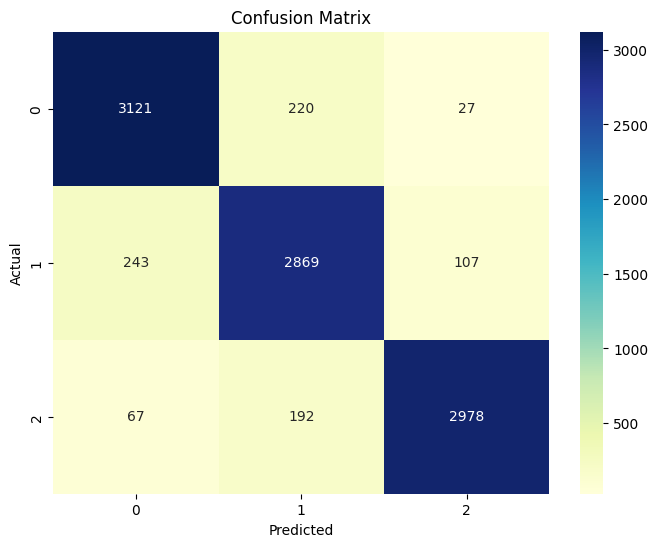

In [76]:
print("Bert + Roberta + Alberta")
combined_preds = np.vstack([all_preds1[:-1], all_preds2[:-1], all_preds3[:-1]])
majority_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=combined_preds)
test_preds = majority_vote.tolist()

# Accuracy
test_accuracy = accuracy_score(test_labels, test_preds)
print("Ensemble Test Accuracy : {:.2f}%".format(test_accuracy * 100))

# F1 Score
f1 = f1_score(test_labels, test_preds, average='weighted')
print("Ensemble F1 Score : {:.2f}%".format(f1 * 100))

# Recall
recall = recall_score(test_labels, test_preds, average='weighted')
print("Ensemble Recall Score : {:.2f}%".format(recall * 100))

# Classification Report
print("Classification Report:")
print(classification_report(test_labels, test_preds))

# Confusion matrix
conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', xticklabels=np.unique(test_labels), yticklabels=np.unique(test_labels))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Roberta + Alberta
Ensemble Test Accuracy : 90.97%
Ensemble F1 Score : 90.99%
Ensemble Recall Score : 90.97%
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      3368
           1       0.87      0.89      0.88      3219
           2       0.96      0.91      0.93      3237

    accuracy                           0.91      9824
   macro avg       0.91      0.91      0.91      9824
weighted avg       0.91      0.91      0.91      9824



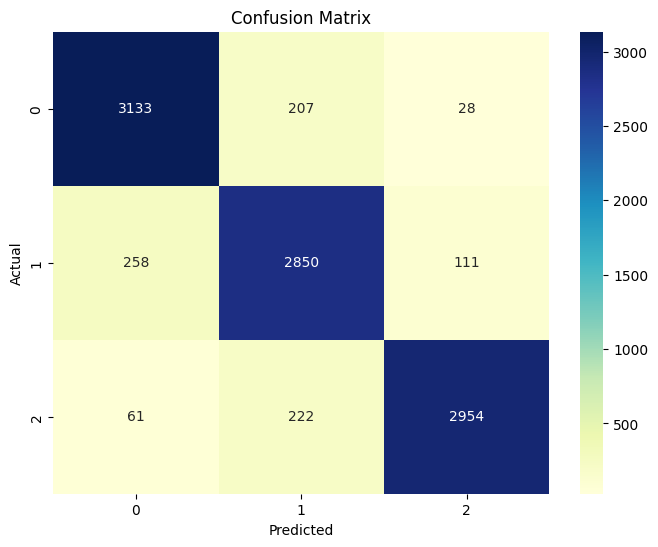

In [78]:
print("Roberta + Alberta")
combined_preds = np.vstack([all_preds2[:-1], all_preds3[:-1]])
majority_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=combined_preds)
test_preds = majority_vote.tolist()

# Accuracy
test_accuracy = accuracy_score(test_labels, test_preds)
print("Ensemble Test Accuracy : {:.2f}%".format(test_accuracy * 100))

# F1 Score
f1 = f1_score(test_labels, test_preds, average='weighted')
print("Ensemble F1 Score : {:.2f}%".format(f1 * 100))

# Recall
recall = recall_score(test_labels, test_preds, average='weighted')
print("Ensemble Recall Score : {:.2f}%".format(recall * 100))

# Classification Report
print("Classification Report:")
print(classification_report(test_labels, test_preds))

# Confusion matrix
conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', xticklabels=np.unique(test_labels), yticklabels=np.unique(test_labels))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Bert + Roberta
Ensemble Test Accuracy : 91.04%
Ensemble F1 Score : 91.07%
Ensemble Recall Score : 91.04%
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      3368
           1       0.87      0.88      0.88      3219
           2       0.96      0.91      0.94      3237

    accuracy                           0.91      9824
   macro avg       0.91      0.91      0.91      9824
weighted avg       0.91      0.91      0.91      9824



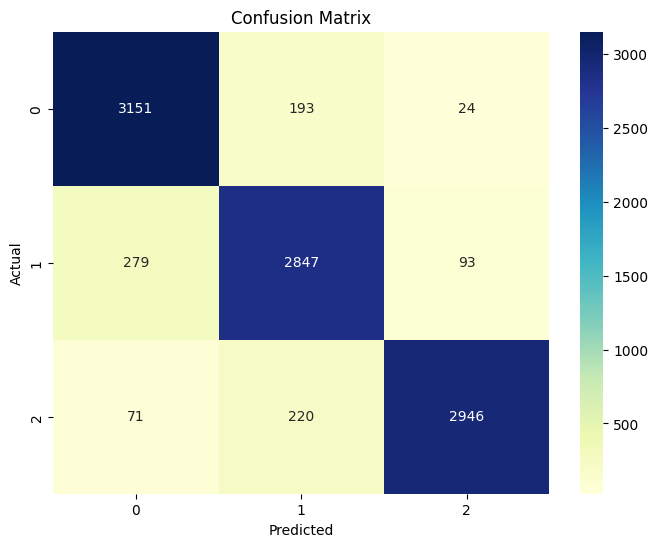

In [79]:
print("Bert + Roberta")
combined_preds = np.vstack([all_preds1[:-1], all_preds2[:-1]])
majority_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=combined_preds)
test_preds = majority_vote.tolist()

# Accuracy
test_accuracy = accuracy_score(test_labels, test_preds)
print("Ensemble Test Accuracy : {:.2f}%".format(test_accuracy * 100))

# F1 Score
f1 = f1_score(test_labels, test_preds, average='weighted')
print("Ensemble F1 Score : {:.2f}%".format(f1 * 100))

# Recall
recall = recall_score(test_labels, test_preds, average='weighted')
print("Ensemble Recall Score : {:.2f}%".format(recall * 100))

# Classification Report
print("Classification Report:")
print(classification_report(test_labels, test_preds))

# Confusion matrix
conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', xticklabels=np.unique(test_labels), yticklabels=np.unique(test_labels))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Bert + Alberta
Ensemble Test Accuracy : 90.65%
Ensemble F1 Score : 90.68%
Ensemble Recall Score : 90.65%
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.92      0.91      3368
           1       0.86      0.89      0.88      3219
           2       0.95      0.91      0.93      3237

    accuracy                           0.91      9824
   macro avg       0.91      0.91      0.91      9824
weighted avg       0.91      0.91      0.91      9824



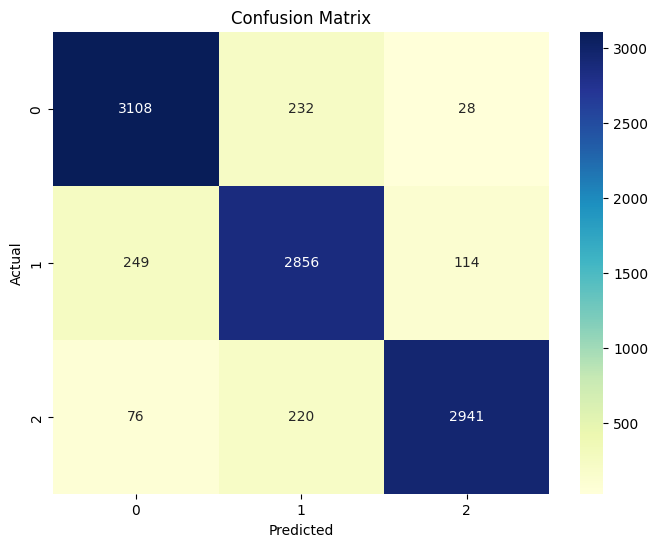

In [80]:
print("Bert + Alberta")
combined_preds = np.vstack([all_preds1[:-1], all_preds3[:-1]])
majority_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=combined_preds)
test_preds = majority_vote.tolist()

# Accuracy
test_accuracy = accuracy_score(test_labels, test_preds)
print("Ensemble Test Accuracy : {:.2f}%".format(test_accuracy * 100))

# F1 Score
f1 = f1_score(test_labels, test_preds, average='weighted')
print("Ensemble F1 Score : {:.2f}%".format(f1 * 100))

# Recall
recall = recall_score(test_labels, test_preds, average='weighted')
print("Ensemble Recall Score : {:.2f}%".format(recall * 100))

# Classification Report
print("Classification Report:")
print(classification_report(test_labels, test_preds))

# Confusion matrix
conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', xticklabels=np.unique(test_labels), yticklabels=np.unique(test_labels))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# **Ensemble + Avg**

Bert + Roberta + Alberta
Ensemble + Average Test Accuracy : 91.61%
Ensemble + Average F1 Score : 91.62%
Ensemble + Average Recall Score : 91.61%


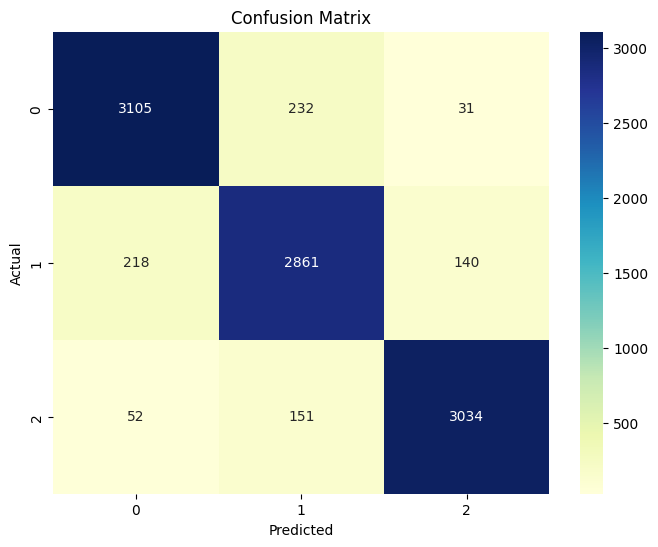

In [88]:
print("Bert + Roberta + Alberta")
combined_preds = np.vstack([all_preds1, all_preds2, all_preds3])
majority_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=combined_preds)
test_preds = majority_vote.tolist()

# Accuracy
test_accuracy = accuracy_score(test_labels, test_preds)
print("Ensemble + Average Test Accuracy : {:.2f}%".format(test_accuracy * 100))

# F1 Score
f1 = f1_score(test_labels, test_preds, average='weighted')
print("Ensemble + Average F1 Score : {:.2f}%".format(f1 * 100))

# Recall
recall = recall_score(test_labels, test_preds, average='weighted')
print("Ensemble + Average Recall Score : {:.2f}%".format(recall * 100))

# Confusion matrix
conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', xticklabels=np.unique(test_labels), yticklabels=np.unique(test_labels))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Roberta + Alberta
Ensemble + Average Test Accuracy : 91.62%
Ensemble + Average F1 Score : 91.63%
Ensemble + Average Recall Score : 91.62%


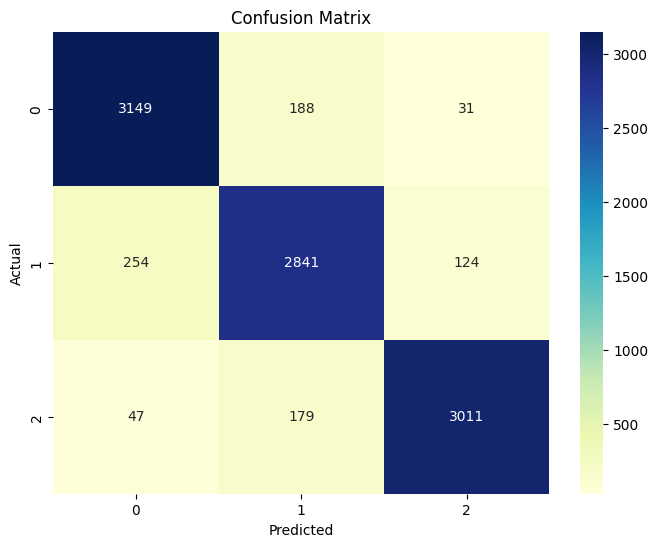

In [89]:
print("Roberta + Alberta")
combined_preds = np.vstack([all_preds2, all_preds3])
majority_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=combined_preds)
test_preds = majority_vote.tolist()

# Accuracy
test_accuracy = accuracy_score(test_labels, test_preds)
print("Ensemble + Average Test Accuracy : {:.2f}%".format(test_accuracy * 100))

# F1 Score
f1 = f1_score(test_labels, test_preds, average='weighted')
print("Ensemble + Average F1 Score : {:.2f}%".format(f1 * 100))

# Recall
recall = recall_score(test_labels, test_preds, average='weighted')
print("Ensemble + Average Recall Score : {:.2f}%".format(recall * 100))

# Confusion matrix
conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', xticklabels=np.unique(test_labels), yticklabels=np.unique(test_labels))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Bert + Roberta
Ensemble + Average Test Accuracy : 91.41%
Ensemble + Average F1 Score : 91.42%
Ensemble + Average Recall Score : 91.41%


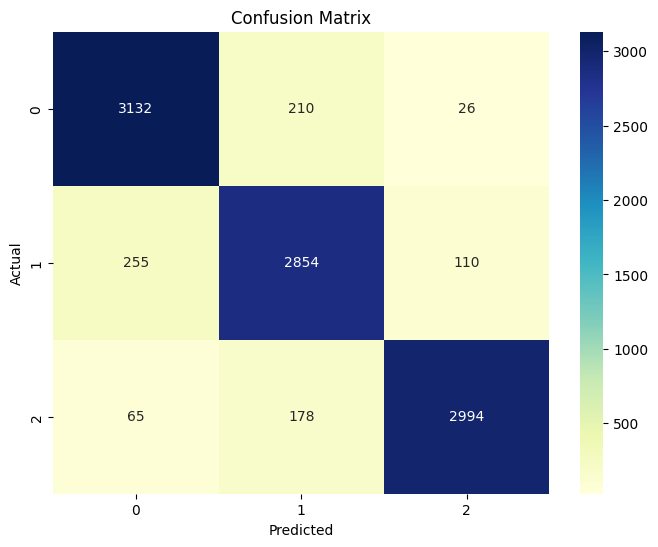

In [90]:
print("Bert + Roberta")
combined_preds = np.vstack([all_preds1, all_preds2])
majority_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=combined_preds)
test_preds = majority_vote.tolist()

# Accuracy
test_accuracy = accuracy_score(test_labels, test_preds)
print("Ensemble + Average Test Accuracy : {:.2f}%".format(test_accuracy * 100))

# F1 Score
f1 = f1_score(test_labels, test_preds, average='weighted')
print("Ensemble + Average F1 Score : {:.2f}%".format(f1 * 100))

# Recall
recall = recall_score(test_labels, test_preds, average='weighted')
print("Ensemble + Average Recall Score : {:.2f}%".format(recall * 100))

# Confusion matrix
conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', xticklabels=np.unique(test_labels), yticklabels=np.unique(test_labels))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Bert + Alberta
Ensemble + Average Test Accuracy : 91.07%
Ensemble + Average F1 Score : 91.09%
Ensemble + Average Recall Score : 91.07%


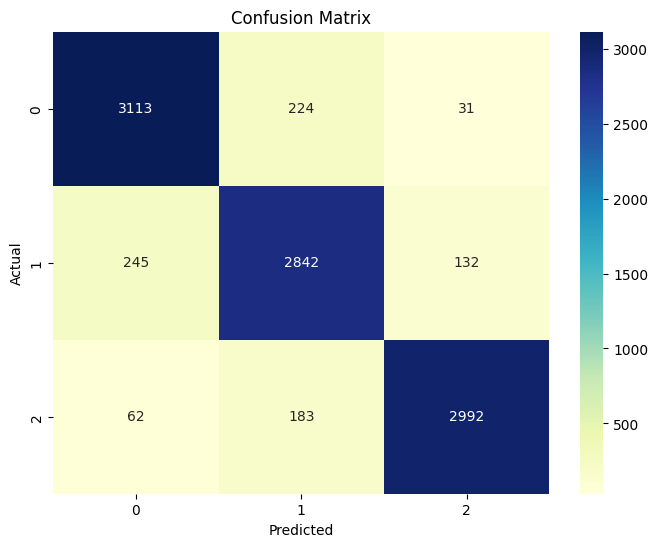

In [91]:
print("Bert + Alberta")
combined_preds = np.vstack([all_preds1, all_preds3])
majority_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=combined_preds)
test_preds = majority_vote.tolist()

# Accuracy
test_accuracy = accuracy_score(test_labels, test_preds)
print("Ensemble + Average Test Accuracy : {:.2f}%".format(test_accuracy * 100))

# F1 Score
f1 = f1_score(test_labels, test_preds, average='weighted')
print("Ensemble + Average F1 Score : {:.2f}%".format(f1 * 100))

# Recall
recall = recall_score(test_labels, test_preds, average='weighted')
print("Ensemble + Average Recall Score : {:.2f}%".format(recall * 100))

# Confusion matrix
conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', xticklabels=np.unique(test_labels), yticklabels=np.unique(test_labels))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [95]:
torch.save(model1, "BERT.pth")
torch.save(model2, "ROBERTA.pth")
torch.save(model3, "ALBERTA.pth")

In [96]:
torch.save(model1, "BERT_final.pth")
torch.save(model2, "ROBERTA_final.pth")
torch.save(model3, "ALBERTA_final.pth")

In [101]:
torch.save(model1.state_dict(), 'model1_state_dict.pth')